# Getting started

MolecularGraph.jl version: 0.10.0

This tutorial includes following fundamental operations of molecular mining.

- Fetch test molecule data from public resources (PubChem)
- Draw chemical structure
- Preprocess molecule data
- Calculate atom/bond descriptors
- Calculate molecular properties
- Find functional groups

## Loading MolecularGraph package

If you cloned the notebook tutorial package according to [Quickstart](https://github.com/mojaie/MolecularGraph.jl_notebook), this notebook file (.ipynb) is located in `notebook` under the package root directory. So `Pkg.activate("..")` to activate the package,  and then load `MolecularGraph`. 

In [1]:
using Pkg
Pkg.activate("..")
using MolecularGraph
using MolecularGraph.Graph

  Activating environment at `~/Repository/MolecularGraph.jl_notebook/Project.toml`
┌ Info: Precompiling MolecularGraph [6c89ec66-9cd8-5372-9f91-fabc50dd27fd]
└ @ Base loading.jl:1317


## Fetching test molecule data from public resources

Chemical structure data for tutorials can be downloaded from PubChem via HTTP. `_data` is created as a temporary data folder, and all test data in this tutorial will be stored in it.

In [2]:
cid = "6437877"  # PubChem CID
name = "Cefditoren Pivoxil"  # FIle name

# Create data directory
data_dir = "_data"
isdir(data_dir) || mkdir(data_dir)

# Fetch
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/$(cid)/SDF"
dest = joinpath(data_dir, "$(name).mol")
isfile(dest) || download(url, dest);

## Chemical structure drawing

From SDFIle

1. Create molecular object from SDFile (.mol or .sdf) by `sdftomol`
1. Generate a SVG format image by `drawsvg`. Image size should be specified (width=300, height=300).
1. `display` the molecule on the notebook.

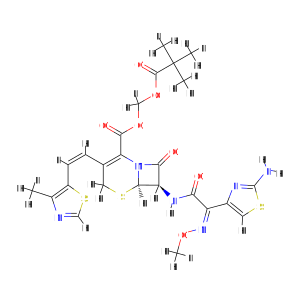

In [3]:
mol = sdftomol(joinpath(data_dir, "Cefditoren Pivoxil.mol"))
molsvg = drawsvg(mol, 300, 300)
display("image/svg+xml",  molsvg)

From SMILES

1. Create molecular object from SMILES string by `smilestomol`.
1. Generate a SVG format image by `drawsvg`. Image size should be specified (width=300, height=300).
1. `display` the molecule on the notebook.

As SMILES does not have coordinates of atoms, so the 2D coordinates will be generated when `smilestomol` is called. Internally `MolecularGraph` uses Schrodinger's [coordgenlibs](https://github.com/schrodinger/coordgenlibs) for 2D coords generation.

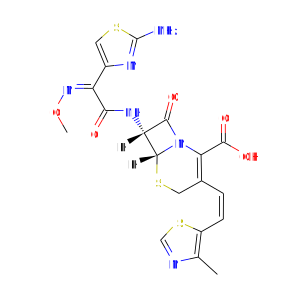

In [4]:
mol2 = smilestomol("O=C3N2/C(=C(/C=C\\c1scnc1C)CS[C@@H]2[C@@H]3NC(=O)C(=N\\OC)/c4nc(sc4)N)C(=O)O")
molsvg2 = drawsvg(mol2, 300, 300)
display("image/svg+xml",  molsvg2)

## Dealing with hydrogens

SDFiles downloaded from PubChem have hydrogen nodes. In practice, hydrogens which is not important are removed from molecular graphs for simplicity.

`removehydrogens(mol, all=false)` removes hyhdrogen nodes that are not important  (no charge, no unpaired electron, no isotope information and no stereochemistry).  If the `all` option is set to `true`,  all hydrogen nodes will be removed.

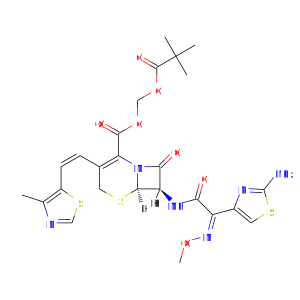

In [5]:
mol = graphmol(removehydrogens(mol, all=false))
molsvg = drawsvg(mol, 300, 300)
display("image/svg+xml",  molsvg)

Even if these hydrogen "nodes" are removed from the graph,  we can infer the actual number of hydrogens from the chemical structure (so called "implicit hydrogens"). `implicithconnected` returns a vector of the number of implicit hydrogens attached to each atom nodes (how to know each atom indices are described later).

In [6]:
println(implicithconnected(mol))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3, 3, 0, 1, 3, 0, 1, 3, 0, 0]


## Basic descriptors

Some other practically useful molecular descriptor methods are listed below.

- `atomsymbol(mol)`: returns atom symbols of each atoms in `Symbol` type
- `charge(mol)`: returns atom charges of each atoms
- `hybridization(mol)`: returns orbital hybridization modes of each atoms
- `isrotatable(mol)`: returns if each bonds are rotatable or not
- `isaromatic(mol)`: returns if each atoms belong to aromatic rings or not
- `isaromaticbond(mol)`: returns if each bonds belong to aromatic rings or not
- `sssr(mol)`: returns smallest set of smallest rings(SSSR)

Running `precalculate!(mol)` before these functions is recommended. This will cache some calculation results of costful and frequently used functions for fast computation.

In [7]:
precalculate!(mol)
println("atomsymbol: \n", atomsymbol(mol), "\n")
println("hybridization: \n", hybridization(mol), "\n")
println("sssr: \n", sssr(mol), "\n")

atomsymbol: 
[:S, :S, :S, :O, :O, :O, :O, :O, :O, :O, :N, :N, :N, :N, :N, :N, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :C, :H, :H]

hybridization: 
[:sp3, :sp3, :sp3, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp3, :sp3, :sp2, :sp2, :sp3, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp3, :sp3, :sp2, :sp2, :sp2, :sp3, :sp3, :sp3, :sp2, :sp2, :sp3, :sp2, :sp2, :sp3, :none, :none]

sssr: 
[[31, 14, 39, 3, 37], [11, 17, 18, 19], [2, 40, 15, 36, 30], [11, 17, 1, 21, 22, 20]]



## Display atom indices

If the molecule is parsed from SDFile, node indices and edge indices are same as the order of SDFile atom/bond records. 

Similary, if the molecule is parsed from SMILES, node indices are same as the order of characters found in SMILES string. Implicit single bonds are also considered as there are `-` characters. Positions of ring bonds are where the ring is closed.

To know which atom is labeled with which index number, `drawatomindex!` can be used.

Internally, `drawsvg` creates `SvgCanvas` object, calls `draw2d!` to set molecule components and then calls `tosvg` to finalize SVG image. `drawatomindex!` adds atom indices to the molecular graph drawing before finalizing.


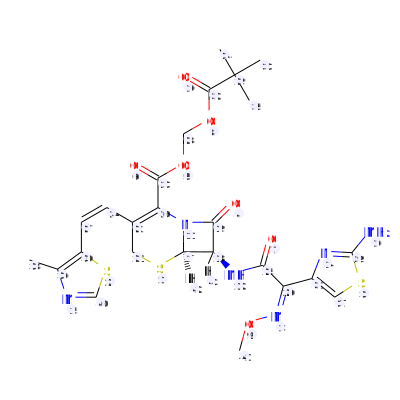

In [8]:
canvas = SvgCanvas()
draw2d!(canvas, mol)
drawatomindex!(canvas, mol)
mol_svg = tosvg(canvas, 400, 400)
display("image/svg+xml",  mol_svg)

## Calculate molecular properties

- `standardweight(Float64, mol)`: returns standard molecular weight.
- `hacceptorcount(mol)`: returns number of Hydrogen bond acceptors (F, O or N).
- `hdonorcount(mol)`: returns number of Hydrogen bond donors (O or N attached to at least one hydrogen).
- `wclogp(mol)` returns predicted LogP value by Wildman and Crippen method. 
- `rotatablecount(mol)` returns number of rotatable bonds.

In [9]:
println("Molecular weight: ", standardweight(Float64, mol))
println("Hydrogen acceptors: ", hacceptorcount(mol))
println("Hydrogen donors: ", hdonorcount(mol))
println("LogP: ", wclogp(mol))
println("Rotatable bonds: ", rotatablecount(mol))

Molecular weight: 620.71
Hydrogen acceptors: 13
Hydrogen donors: 2
LogP: 2.3
Rotatable bonds: 13


## Substructure search / molecular query

`hassubstructmatch` is a convenient function to find substructure (or query) matches. 

In [10]:
substr = smilestomol("s1cncc1")
println(hassubstructmatch(mol, substr))
query = smartstomol(raw"[$([N;r]A=A)]")  # non-aromatic ring nitrogen adjacent to double bond
println(hassubstructmatch(mol, query))

true
true


`substructmatches` returns an iterator that yields mappings of matched nodes.

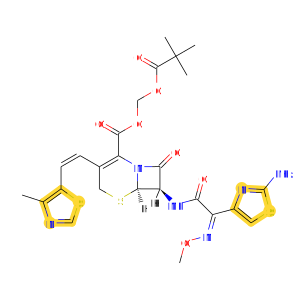

In [11]:
matched1 = Set(Iterators.flatten(keys(m) for m in substructmatches(mol, substr)))
subg1 = nodesubgraph(mol, matched1)
svg1 = drawsvg(mol, 300, 300, highlight=subg1)
display("image/svg+xml", svg1)

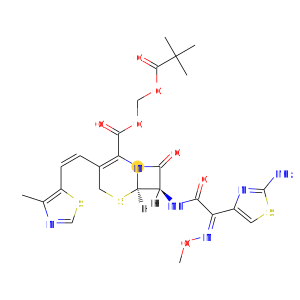

In [12]:
matched2 = iterate(substructmatches(mol, query))[1]
subg2 = nodesubgraph(mol, keys(matched2))
svg2 = drawsvg(mol, 300, 300, highlight=subg2)
display("image/svg+xml", svg2)

## Query-based substructure mining

Query-based substructure mining is often used to classify compounds by their characteristics, and to predict their reactivity, toxicity or physical properties.
`MolecularGraph.jl` provides a default query set as a YAML file for an example of simple functional group mining. This can be easily extended for some applications like structural alert or toxicity prediction (See query-based substructure mining tutorial for details).

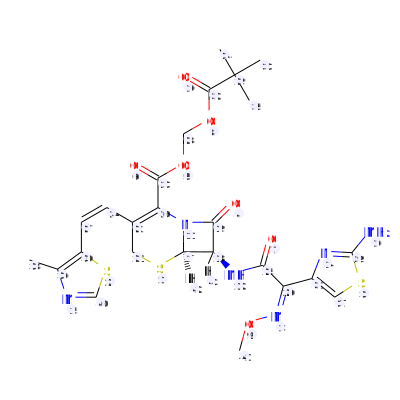

Group: Cys: Set([[1, 4, 12, 17, 18, 19]])
Group: Diene: Set([[20, 22, 24, 27]])
Group: Acetal: Set([[5, 8, 23, 28, 32]])
Group: Pivoxil: Set([[5, 8, 10, 28, 29, 32, 33, 34, 35]])
Group: PrimaryAmine: Set([[16]])
Group: ArylAmine: Set([[16]])
Group: SecondaryAmide: Set([[7, 12, 18, 25]])
Group: TertiaryAmide: Set([[4, 11, 17, 19, 20]])
Group: Oxime: Set([[9, 13, 26]])
Group: Thioether: Set([[1, 17, 21]])
Group: Thiazole: Set([[2, 15, 30, 36, 40], [3, 14, 31, 37, 39]])
Group: BetaLactam: Set([[4, 11, 17, 18, 19]])


In [14]:
qr = query_relationship()
flt = filter_queries(qr, mol)

display("image/svg+xml",  mol_svg)

for n in 1:nodecount(flt)
    indegree(flt, n) == 0 || continue
    key = nodeattr(flt, n)["key"]
    matched = nodeattr(flt, n)["matched"]
    println("Group: $(key): ", matched)
end